# M4 Industrial Time Series Meta Learning Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp

In [2]:
np.random.seed(23)
w.simplefilter("ignore")

## Make Meta Target

In [3]:
trotta = pd.read_csv("../Metrics/trotta.csv", index_col=0)
alves = pd.read_csv("../Metrics/alves.csv", index_col=0)
muk = pd.read_csv("../Metrics/muk.csv", index_col=0)
rnn = pd.read_csv("../Metrics/rnn.csv", index_col=0)
pelka = pd.read_csv("../Metrics/pelka.csv", index_col=0)
mlp = pd.read_csv("../Metrics/mlp.csv", index_col=0)
theta = pd.read_csv("../Metrics/theta.csv", index_col=0)
arima = pd.read_csv("../Metrics/arima.csv", index_col=0)
damped = pd.read_csv("../Metrics/damped.csv", index_col=0)
ets = pd.read_csv("../Metrics/ets.csv", index_col=0)
holt = pd.read_csv("../Metrics/holt.csv", index_col=0)
ses = pd.read_csv("../Metrics/ses.csv", index_col=0)

In [4]:
mask = {
    "Y":trotta.index.str.startswith("Y"),
    "Q":trotta.index.str.startswith("Q"),
    "M":trotta.index.str.startswith("M")
}

In [5]:
group0 = {
    "Y":np.apply_along_axis(
        np.mean, 
        0, 
        np.array(
            [
                trotta[mask["Y"]]["OWA"], alves[mask["Y"]]["OWA"], muk[mask["Y"]]["OWA"], 
                rnn[mask["Y"]]["OWA"], pelka[mask["Y"]]["OWA"], mlp[mask["Y"]]["OWA"]
            ]
        )
    ),
    "Q":np.apply_along_axis(
        np.mean, 
        0, 
        np.array(
            [
                trotta[mask["Q"]]["OWA"], alves[mask["Q"]]["OWA"], muk[mask["Q"]]["OWA"], 
                rnn[mask["Q"]]["OWA"], pelka[mask["Q"]]["OWA"], mlp[mask["Q"]]["OWA"]
            ]
        )
    ),
    "M":np.apply_along_axis(
        np.mean, 
        0, 
        np.array(
            [
                trotta[mask["M"]]["OWA"], alves[mask["M"]]["OWA"], muk[mask["M"]]["OWA"], 
                rnn[mask["M"]]["OWA"], pelka[mask["M"]]["OWA"], mlp[mask["M"]]["OWA"]
            ]
        )
    )
}

In [6]:
group1 = {
    "Y":np.apply_along_axis(
        np.mean, 
        0, 
        np.array(
            [
                theta[mask["Y"]]["OWA"], arima[mask["Y"]]["OWA"], damped[mask["Y"]]["OWA"], 
                ets[mask["Y"]]["OWA"], holt[mask["Y"]]["OWA"], ses[mask["Y"]]["OWA"]
            ]
        )
    ),
    "Q":np.apply_along_axis(
        np.mean, 
        0, 
        np.array(
            [
                theta[mask["Q"]]["OWA"], arima[mask["Q"]]["OWA"], damped[mask["Q"]]["OWA"], 
                ets[mask["Q"]]["OWA"], holt[mask["Q"]]["OWA"], ses[mask["Q"]]["OWA"]
            ]
        )
    ),
    "M":np.apply_along_axis(
        np.mean, 
        0, 
        np.array(
            [
                theta[mask["M"]]["OWA"], arima[mask["M"]]["OWA"], damped[mask["M"]]["OWA"], 
                ets[mask["M"]]["OWA"], holt[mask["M"]]["OWA"], ses[mask["M"]]["OWA"]
            ]
        )
    )
}

In [7]:
target = {
    "Y":(group1["Y"] < group0["Y"]).astype("int"),
    "Q":(group1["Q"] < group0["Q"]).astype("int"),
    "M":(group1["M"] < group0["M"]).astype("int")
}

## Collects the Meta Features

In [8]:
groups = os.listdir("../Meta Features/groups")
groups = [file_name.split(".")[0] for file_name in groups]

In [9]:
data = {
    "Y":pd.concat([pd.read_csv("../Meta Features/Yearly/"+group+".csv", index_col=0) for group in groups], axis=1),
    "Q":pd.concat([pd.read_csv("../Meta Features/Quarterly/"+group+".csv", index_col=0) for group in groups], axis=1),
    "M":pd.concat([pd.read_csv("../Meta Features/Monthly/"+group+".csv", index_col=0) for group in groups], axis=1)
}

In [10]:
for d in data.items():
    d[1]["target"] = target[d[0]]
    d[1].index = trotta.index[mask[d[0]]]


## Shows the Datasets

In [11]:
data["Y"].head()

,itrand_acf.mean,itrand_acf.sd,itrand_mean.mean,itrand_mean.sd,itrand_sd.mean,itrand_sd.sd,resample_first_acf_locmin.mean,resample_first_acf_locmin.sd,resample_first_acf_nonpos.mean,resample_first_acf_nonpos.sd,...,gresid_lbtest.sd,pacf.mean,pacf.sd,pacf_detrended.mean,pacf_detrended.sd,pacf_diff.mean,pacf_diff.sd,tc3,trev,target
M4id,,,,,,,,,,,,,,,,,,,,,
Y11530,-0.066463,0.268739,1385.229687,42.760593,192.192518,22.695417,NaN,NaN,1.968750,0.174676,...,0.055455,0.078993,0.591627,-0.268876,0.320152,-0.268876,0.320152,1.030897,-0.946934,1
Y11531,0.172769,0.311569,6686.652273,469.022002,2273.269869,842.071489,NaN,NaN,1.953125,0.212202,...,0.338159,0.487571,0.854626,0.059079,0.816096,0.059079,0.816096,1.385558,1.604026,1
Y11532,0.052972,0.277324,6567.741477,188.557995,1669.864279,58.699450,NaN,NaN,2.000000,0.000000,...,0.117274,0.251990,0.825854,-0.405792,0.657132,-0.405792,0.657132,1.086273,0.475033,1
Y11533,0.160520,0.270289,9391.510795,204.881228,1182.430306,78.182864,NaN,NaN,2.000000,0.000000,...,0.271085,0.350862,0.617724,-0.194238,0.432671,-0.194238,0.432671,1.035620,1.323007,1
Y11534,0.078727,0.251907,1476.775767,12.924323,98.344075,10.499741,NaN,NaN,2.000000,0.000000,...,0.138739,-0.082482,0.856831,-0.402375,0.526383,-0.402375,0.526383,1.006626,-0.900103,1


In [12]:
data["Q"].head()

,itrand_acf.mean,itrand_acf.sd,itrand_mean.mean,itrand_mean.sd,itrand_sd.mean,itrand_sd.sd,resample_first_acf_locmin.mean,resample_first_acf_locmin.sd,resample_first_acf_nonpos.mean,resample_first_acf_nonpos.sd,...,gresid_lbtest.sd,pacf.mean,pacf.sd,pacf_detrended.mean,pacf_detrended.sd,pacf_diff.mean,pacf_diff.sd,tc3,trev,target
M4id,,,,,,,,,,,,,,,,,,,,,
Q13194,0.199977,0.310148,7039.470974,58.289196,521.607860,27.876489,NaN,NaN,2.0,0.0,...,0.076307,0.399837,0.458359,0.200558,0.391023,0.200558,0.391023,0.997270,-1.028514,1
Q13195,0.108026,0.313458,7567.418679,88.907116,494.651959,21.701125,NaN,NaN,2.0,0.0,...,0.027457,0.460382,0.466834,0.292765,0.331410,0.292765,0.331410,0.998055,-1.360875,1
Q13196,0.123783,0.301141,7295.080494,73.411909,452.142325,29.727639,NaN,NaN,2.0,0.0,...,0.159885,0.377442,0.518067,-0.285744,0.211623,-0.285744,0.211623,0.995062,-1.872936,1
Q13197,0.008315,0.352115,7106.866782,72.172612,407.092305,73.932985,NaN,NaN,2.0,0.0,...,0.205198,0.293668,0.616591,0.236492,0.499109,0.236492,0.499109,1.000964,-0.252565,1
Q13198,0.222095,0.319726,7643.124404,124.551987,547.575754,67.566347,NaN,NaN,2.0,0.0,...,0.032027,0.177944,0.754076,-0.187636,0.075444,-0.187636,0.075444,1.002818,-1.768906,1


In [13]:
data["M"].head()

,itrand_acf.mean,itrand_acf.sd,itrand_mean.mean,itrand_mean.sd,itrand_sd.mean,itrand_sd.sd,resample_first_acf_locmin.mean,resample_first_acf_locmin.sd,resample_first_acf_nonpos.mean,resample_first_acf_nonpos.sd,...,gresid_lbtest.sd,pacf.mean,pacf.sd,pacf_detrended.mean,pacf_detrended.sd,pacf_diff.mean,pacf_diff.sd,tc3,trev,target
M4id,,,,,,,,,,,,,,,,,,,,,
M26720,0.195578,0.258568,8625.952911,52.300957,1269.375763,33.985550,2.562500,0.839479,2.179688,0.725612,...,7.021961e-74,0.015460,0.157277,-0.007496,0.125030,-0.007496,0.125030,1.027549,0.067067,1
M26721,0.264611,0.297153,1562.267025,24.751649,450.459781,18.156295,2.648438,0.622287,2.007812,0.198264,...,2.478702e-28,0.028387,0.276583,-0.037277,0.218651,-0.037277,0.218651,1.054609,1.464012,1
M26722,0.229050,0.285223,2083.457418,5.333789,288.159886,3.160549,6.085938,0.281373,3.703125,0.458676,...,0.000000e+00,0.014019,0.157442,-0.007141,0.154658,-0.007141,0.154658,1.024754,0.087065,1
M26723,0.209233,0.224399,3974.004464,7.621932,66.026953,4.854323,2.539062,0.912747,1.171875,0.399002,...,5.447215e-09,0.171046,0.248708,-0.027976,0.280189,-0.027976,0.280189,1.001072,-0.017480,1
M26724,0.195509,0.376233,8942.745536,93.927436,845.137927,47.900700,2.421875,0.727517,1.945312,0.422005,...,1.739953e-18,0.054273,0.362841,-0.000512,0.392659,-0.000512,0.392659,1.002617,-0.730909,1


## Data Cleaning

In [14]:
complex_feats = ("low_freq_power", "ps_residuals.mean", "ps_residuals.sd")
rows_to_drop = {
    "Y":None, "Q":None, "M":None
}
nan_threshold = 50
const_threshold = 1e-2
corr_threshold = 0.95

for d in data.items():
    for f in complex_feats:
        d[1][f] = d[1][f].apply(lambda x:complex(x).real)
        
    isnan = d[1].isna().sum()
    d[1].drop(isnan[isnan>=nan_threshold].index, axis=1, inplace=True)
    rows_to_drop[d[0]] = d[1][d[1].isna().any(axis=1)].index
    d[1].drop(rows_to_drop[d[0]], axis=0, inplace=True)
    
    std = d[1].std()
    d[1].drop(std[std<const_threshold].index, axis=1, inplace=True)
    
    corr_matrix = d[1].drop("target", axis=1).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    d[1].drop(to_drop, axis=1, inplace=True)

In [15]:
for d in data.items():
    print(d[1].shape)

(3600, 100)
(4534, 118)
(9957, 122)


In [16]:
titles = ("YEARLY", "QUARTERLY", "MONTHLY")

## Target Distribution

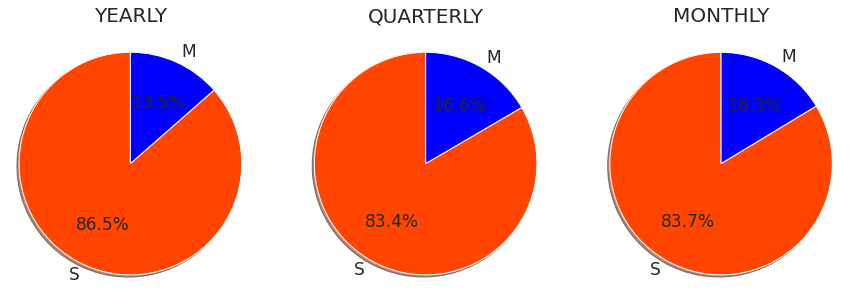

In [52]:
labels = ("S", "M")
sizes = {
    "Y":100*data["Y"].target.value_counts()/len(data["Y"]),
    "Q":100*data["Q"].target.value_counts()/len(data["Q"]),
    "M":100*data["M"].target.value_counts()/len(data["M"])
}

fig1, ax1 = plt.subplots(1, 3, figsize=(15, 5))
for i, d in enumerate(sizes.items()):
    ax1[i].pie(d[1].values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 17}, colors=["orangered", "blue"])
    ax1[i].axis('equal')
    ax1[i].set_title(titles[i], fontsize=20)
plt.savefig("pie.png")

In [18]:
X = {
    "Y":data["Y"].drop("target", axis=1).values,
    "Q":data["Q"].drop("target", axis=1).values,
    "M":data["M"].drop("target", axis=1).values
}
y = {
    "Y":data["Y"].target,
    "Q":data["Q"].target,
    "M":data["M"].target
}

## PCA Plot

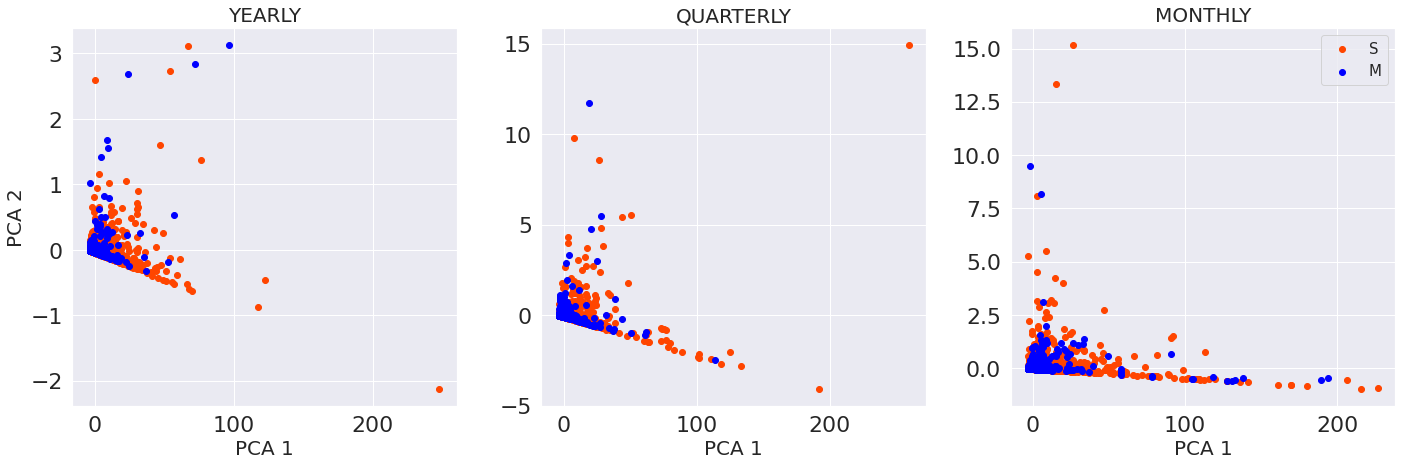

In [42]:
pca = PCA(n_components=2)
X_pca = {
    "Y":pca.fit_transform((X["Y"]-X["Y"].mean())/X["Y"].std()),
    "Q":pca.fit_transform((X["Q"]-X["Q"].mean())/X["Q"].std()),
    "M":pca.fit_transform((X["M"]-X["M"].mean())/X["M"].std())
}

fig1, ax1 = plt.subplots(1, 3, figsize=(20, 7))

ax1[0].scatter(X_pca["Y"][y["Y"]==1, 0], X_pca["Y"][y["Y"]==1, 1], color="orangered", label="S")
ax1[0].scatter(X_pca["Y"][y["Y"]==0, 0], X_pca["Y"][y["Y"]==0, 1], color="blue", label="M")
ax1[0].set_xlabel("PCA 1", fontsize=20)
ax1[0].set_ylabel("PCA 2", fontsize=20)
ax1[0].set_title("YEARLY", fontsize=20)

ax1[1].scatter(X_pca["Q"][y["Q"]==1, 0], X_pca["Q"][y["Q"]==1, 1], color="orangered", label="S")
ax1[1].scatter(X_pca["Q"][y["Q"]==0, 0], X_pca["Q"][y["Q"]==0, 1], color="blue", label="M")
ax1[1].set_xlabel("PCA 1", fontsize=20)
ax1[1].set_title("QUARTERLY", fontsize=20)

ax1[2].scatter(X_pca["M"][y["M"]==1, 0], X_pca["M"][y["M"]==1, 1], color="orangered", label="S")
ax1[2].scatter(X_pca["M"][y["M"]==0, 0], X_pca["M"][y["M"]==0, 1], color="blue", label="M")
ax1[2].legend(fontsize=15)
ax1[2].set_xlabel("PCA 1", fontsize=20)
ax1[2].set_title("MONTHLY", fontsize=20)

plt.tight_layout()
plt.savefig("pca.png")

## Meta Learner Training and Predicting

In [20]:
recommendations = {
    "Y":{"predicted":None, "actual":None},
    "Q":{"predicted":None, "actual":None},
    "M":{"predicted":None, "actual":None}
}

feature_importances = {
    "Y":[], "Q":[], "M":[]
}

for interval in ("Y", "Q", "M"):
    y_pred, y_true = np.zeros(y[interval].shape[0]), np.zeros(y[interval].shape[0])
    coefs = []
    for train_idxs, test_idxs in StratifiedKFold(n_splits=10).split(X[interval], y[interval]):
        X_train, y_train = X[interval][train_idxs,:], y[interval][train_idxs]
        X_test, y_test = X[interval][test_idxs,:], y[interval][test_idxs]
    
        model = RandomForestClassifier(max_depth=5, class_weight="balanced", min_samples_split=5)
        model.fit(X_train, y_train)
    
        coefs.append(model.feature_importances_)
    
        y_pred[test_idxs] = model.predict(X_test)
        y_true[test_idxs] = y_test
        
    recommendations[interval]["predicted"] = y_pred
    recommendations[interval]["actual"] = y_true
    feature_importances[interval] = coefs

## Confusion Matrix

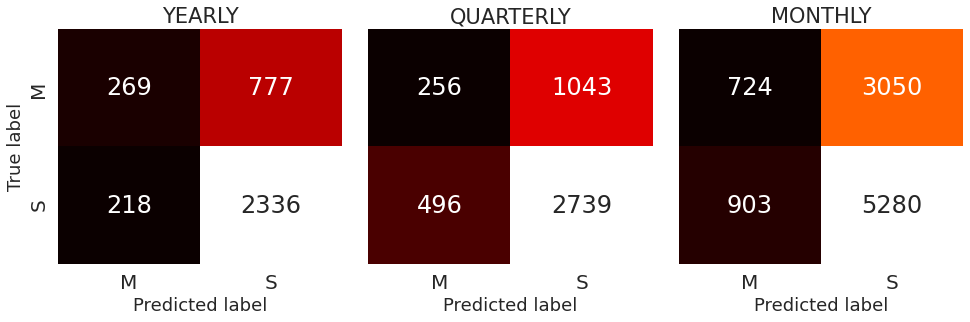

In [45]:
fig1, ax1 = plt.subplots(1, 3, figsize=(14, 5))
sns.set(font_scale=2.0)

sns.heatmap(
    confusion_matrix(recommendations["Y"]["predicted"], recommendations["Y"]["actual"]), 
    annot=True, ax=ax1[0], cmap="hot", fmt="g", cbar=False)
ax1[0].set_xlabel('Predicted label', fontdict={'size':'18'})
ax1[0].set_ylabel('True label', fontdict={'size':'18'})
ax1[0].set_title('YEARLY', fontdict={'size':'21'})
ax1[0].xaxis.set_ticklabels(['M', 'S'], fontsize=20)
ax1[0].yaxis.set_ticklabels(['M', 'S'], fontsize=20)

sns.heatmap(
    confusion_matrix(recommendations["Q"]["predicted"], recommendations["Q"]["actual"]), 
    annot=True, ax=ax1[1], cmap="hot", fmt="g", cbar=False)
ax1[1].set_xlabel('Predicted label', fontdict={'size':'18'})
ax1[1].set_title('QUARTERLY', fontdict={'size':'21'})
ax1[1].xaxis.set_ticklabels(['M', 'S'], fontsize=20)
ax1[1].yaxis.set_ticklabels(['', ''], fontsize=20)

sns.heatmap(
    confusion_matrix(recommendations["M"]["predicted"], recommendations["M"]["actual"]), 
    annot=True, ax=ax1[2], cmap="hot", fmt="g", cbar=False)
ax1[2].set_xlabel('Predicted label', fontdict={'size':'18'})
ax1[2].set_title('MONTHLY', fontdict={'size':'21'})
ax1[2].xaxis.set_ticklabels(['M', 'S'], fontsize=20)
ax1[2].yaxis.set_ticklabels(['', ''], fontsize=20)
plt.tight_layout()
plt.savefig("cm.png")

## Feature Importances

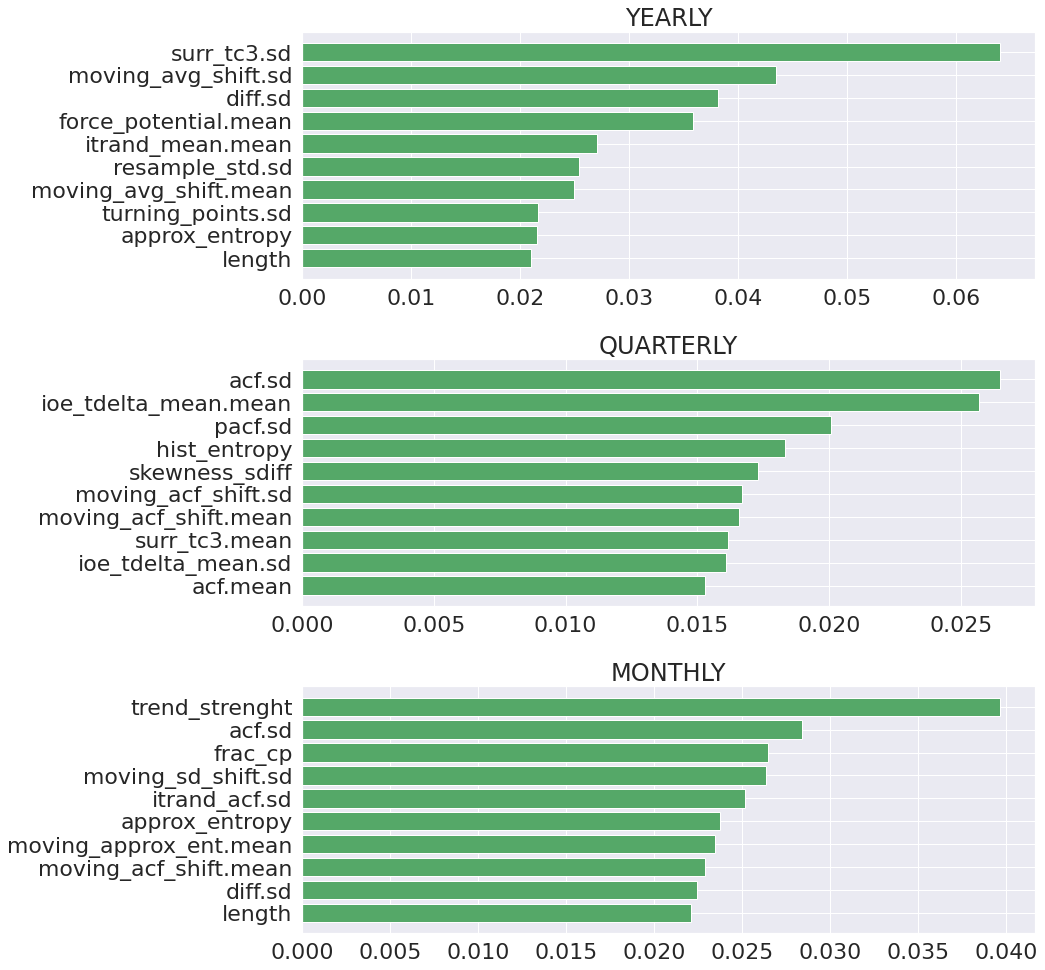

In [51]:
feat_df = {
    "Y":pd.DataFrame({"name":data["Y"].drop("target", axis=1).columns, "score":np.array(feature_importances["Y"]).mean(axis=0)}),
    "Q":pd.DataFrame({"name":data["Q"].drop("target", axis=1).columns, "score":np.array(feature_importances["Q"]).mean(axis=0)}),
    "M":pd.DataFrame({"name":data["M"].drop("target", axis=1).columns, "score":np.array(feature_importances["M"]).mean(axis=0)})
}

fig1, ax1 = plt.subplots(3, 1, figsize=(15, 14))

for i, d in enumerate(feat_df.items()):
    top = d[1].sort_values(by="score", ascending=False)[:10][::-1]
    ax1[i].barh(top.name, top.score, color="g")
    ax1[i].set_title(titles[i])
plt.tight_layout()
plt.savefig("featimp.png")

## Meta Learner Evaluation

In [23]:
predictions_filtered = {
    "Y":{
        "trotta":trotta[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "alves":alves[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "muk":muk[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "rnn":rnn[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "pelka":pelka[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "mlp":mlp[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "theta":theta[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "arima":arima[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "damped":damped[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "ets":ets[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "holt":holt[mask["Y"]].drop(rows_to_drop["Y"], axis=0),
        "ses":ses[mask["Y"]].drop(rows_to_drop["Y"], axis=0)
    },
    "Q":{
        "trotta":trotta[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "alves":alves[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "muk":muk[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "rnn":rnn[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "pelka":pelka[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "mlp":mlp[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "theta":theta[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "arima":arima[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "damped":damped[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "ets":ets[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "holt":holt[mask["Q"]].drop(rows_to_drop["Q"], axis=0),
        "ses":ses[mask["Q"]].drop(rows_to_drop["Q"], axis=0)
    },
    "M":{
        "trotta":trotta[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "alves":alves[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "muk":muk[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "rnn":rnn[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "pelka":pelka[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "mlp":mlp[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "theta":theta[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "arima":arima[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "damped":damped[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "ets":ets[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "holt":holt[mask["M"]].drop(rows_to_drop["M"], axis=0),
        "ses":ses[mask["M"]].drop(rows_to_drop["M"], axis=0)
    }
    
}

In [24]:
mean = lambda x: np.apply_along_axis(np.mean, 0, x)

group0 = {
    "Y":{
        "SMAPE":mean(
            np.array([
                predictions_filtered["Y"]["trotta"]["SMAPE"], 
                predictions_filtered["Y"]["alves"]["SMAPE"], 
                predictions_filtered["Y"]["muk"]["SMAPE"], 
                predictions_filtered["Y"]["rnn"]["SMAPE"], 
                predictions_filtered["Y"]["pelka"]["SMAPE"], 
                predictions_filtered["Y"]["mlp"]["SMAPE"]
            ])
        ), 
        "MASE":mean(
            np.array([
                predictions_filtered["Y"]["trotta"]["MASE"], 
                predictions_filtered["Y"]["alves"]["MASE"], 
                predictions_filtered["Y"]["muk"]["MASE"], 
                predictions_filtered["Y"]["rnn"]["MASE"], 
                predictions_filtered["Y"]["pelka"]["MASE"], 
                predictions_filtered["Y"]["mlp"]["MASE"]
            ])
        ),
        "OWA":mean(
            np.array([
                predictions_filtered["Y"]["trotta"]["OWA"], 
                predictions_filtered["Y"]["alves"]["OWA"], 
                predictions_filtered["Y"]["muk"]["OWA"], 
                predictions_filtered["Y"]["rnn"]["OWA"], 
                predictions_filtered["Y"]["pelka"]["OWA"], 
                predictions_filtered["Y"]["mlp"]["OWA"]
            ])
        ),
    },
    "Q":{
        "SMAPE":mean(
            np.array([
                predictions_filtered["Q"]["trotta"]["SMAPE"], 
                predictions_filtered["Q"]["alves"]["SMAPE"], 
                predictions_filtered["Q"]["muk"]["SMAPE"], 
                predictions_filtered["Q"]["rnn"]["SMAPE"], 
                predictions_filtered["Q"]["pelka"]["SMAPE"], 
                predictions_filtered["Q"]["mlp"]["SMAPE"]
            ])
        ), 
        "MASE":mean(
            np.array([
                predictions_filtered["Q"]["trotta"]["MASE"], 
                predictions_filtered["Q"]["alves"]["MASE"], 
                predictions_filtered["Q"]["muk"]["MASE"], 
                predictions_filtered["Q"]["rnn"]["MASE"], 
                predictions_filtered["Q"]["pelka"]["MASE"], 
                predictions_filtered["Q"]["mlp"]["MASE"]
            ])
        ),
        "OWA":mean(
            np.array([
                predictions_filtered["Q"]["trotta"]["OWA"], 
                predictions_filtered["Q"]["alves"]["OWA"], 
                predictions_filtered["Q"]["muk"]["OWA"], 
                predictions_filtered["Q"]["rnn"]["OWA"], 
                predictions_filtered["Q"]["pelka"]["OWA"], 
                predictions_filtered["Q"]["mlp"]["OWA"]
            ])
        ),
    },
    "M":{
        "SMAPE":mean(
            np.array([
                predictions_filtered["M"]["trotta"]["SMAPE"], 
                predictions_filtered["M"]["alves"]["SMAPE"], 
                predictions_filtered["M"]["muk"]["SMAPE"], 
                predictions_filtered["M"]["rnn"]["SMAPE"], 
                predictions_filtered["M"]["pelka"]["SMAPE"], 
                predictions_filtered["M"]["mlp"]["SMAPE"]
            ])
        ), 
        "MASE":mean(
            np.array([
                predictions_filtered["M"]["trotta"]["MASE"], 
                predictions_filtered["M"]["alves"]["MASE"], 
                predictions_filtered["M"]["muk"]["MASE"], 
                predictions_filtered["M"]["rnn"]["MASE"], 
                predictions_filtered["M"]["pelka"]["MASE"], 
                predictions_filtered["M"]["mlp"]["MASE"]
            ])
        ),
        "OWA":mean(
            np.array([
                predictions_filtered["M"]["trotta"]["OWA"], 
                predictions_filtered["M"]["alves"]["OWA"], 
                predictions_filtered["M"]["muk"]["OWA"], 
                predictions_filtered["M"]["rnn"]["OWA"], 
                predictions_filtered["M"]["pelka"]["OWA"], 
                predictions_filtered["M"]["mlp"]["OWA"]
            ])
        ),
    },
}

group1 = {
    "Y":{
        "SMAPE":mean(
            np.array([
                predictions_filtered["Y"]["theta"]["SMAPE"], 
                predictions_filtered["Y"]["arima"]["SMAPE"], 
                predictions_filtered["Y"]["damped"]["SMAPE"], 
                predictions_filtered["Y"]["ets"]["SMAPE"], 
                predictions_filtered["Y"]["holt"]["SMAPE"], 
                predictions_filtered["Y"]["ses"]["SMAPE"]
            ])
        ), 
        "MASE":mean(
            np.array([
                predictions_filtered["Y"]["theta"]["MASE"], 
                predictions_filtered["Y"]["arima"]["MASE"], 
                predictions_filtered["Y"]["damped"]["MASE"], 
                predictions_filtered["Y"]["ets"]["MASE"], 
                predictions_filtered["Y"]["holt"]["MASE"], 
                predictions_filtered["Y"]["ses"]["MASE"]
            ])
        ),
        "OWA":mean(
            np.array([
                predictions_filtered["Y"]["theta"]["OWA"], 
                predictions_filtered["Y"]["arima"]["OWA"], 
                predictions_filtered["Y"]["damped"]["OWA"], 
                predictions_filtered["Y"]["ets"]["OWA"], 
                predictions_filtered["Y"]["holt"]["OWA"], 
                predictions_filtered["Y"]["ses"]["OWA"]
            ])
        ),
    },
    "Q":{
        "SMAPE":mean(
            np.array([
                predictions_filtered["Q"]["theta"]["SMAPE"], 
                predictions_filtered["Q"]["arima"]["SMAPE"], 
                predictions_filtered["Q"]["damped"]["SMAPE"], 
                predictions_filtered["Q"]["ets"]["SMAPE"], 
                predictions_filtered["Q"]["holt"]["SMAPE"], 
                predictions_filtered["Q"]["ses"]["SMAPE"]
            ])
        ), 
        "MASE":mean(
            np.array([
                predictions_filtered["Q"]["theta"]["MASE"], 
                predictions_filtered["Q"]["arima"]["MASE"], 
                predictions_filtered["Q"]["damped"]["MASE"], 
                predictions_filtered["Q"]["ets"]["MASE"], 
                predictions_filtered["Q"]["holt"]["MASE"], 
                predictions_filtered["Q"]["ses"]["MASE"]
            ])
        ),
        "OWA":mean(
            np.array([
                predictions_filtered["Q"]["theta"]["OWA"], 
                predictions_filtered["Q"]["arima"]["OWA"], 
                predictions_filtered["Q"]["damped"]["OWA"], 
                predictions_filtered["Q"]["ets"]["OWA"], 
                predictions_filtered["Q"]["holt"]["OWA"], 
                predictions_filtered["Q"]["ses"]["OWA"]
            ])
        ),
    },
    "M":{
        "SMAPE":mean(
            np.array([
                predictions_filtered["M"]["theta"]["SMAPE"], 
                predictions_filtered["M"]["arima"]["SMAPE"], 
                predictions_filtered["M"]["damped"]["SMAPE"], 
                predictions_filtered["M"]["ets"]["SMAPE"], 
                predictions_filtered["M"]["holt"]["SMAPE"], 
                predictions_filtered["M"]["ses"]["SMAPE"]
            ])
        ), 
        "MASE":mean(
            np.array([
                predictions_filtered["M"]["theta"]["MASE"], 
                predictions_filtered["M"]["arima"]["MASE"], 
                predictions_filtered["M"]["damped"]["MASE"], 
                predictions_filtered["M"]["ets"]["MASE"], 
                predictions_filtered["M"]["holt"]["MASE"], 
                predictions_filtered["M"]["ses"]["MASE"]
            ])
        ),
        "OWA":mean(
            np.array([
                predictions_filtered["M"]["theta"]["OWA"], 
                predictions_filtered["M"]["arima"]["OWA"], 
                predictions_filtered["M"]["damped"]["OWA"], 
                predictions_filtered["M"]["ets"]["OWA"], 
                predictions_filtered["M"]["holt"]["OWA"], 
                predictions_filtered["M"]["ses"]["OWA"]
            ])
        ),
    }
}

In [25]:
def meta_learner_metrics(group0:dict, group1:dict, predictions:np.ndarray)->dict:
    meta_learner = {"SMAPE":[], "MASE":[], "OWA":[]}
    for i, y in enumerate(predictions):
        if y==0:
            meta_learner["SMAPE"].append(group0["SMAPE"][i])
            meta_learner["MASE"].append(group0["MASE"][i])
            meta_learner["OWA"].append(group0["OWA"][i])
        else:
            meta_learner["SMAPE"].append(group1["SMAPE"][i])
            meta_learner["MASE"].append(group1["MASE"][i])
            meta_learner["OWA"].append(group1["OWA"][i])
        
    meta_learner["SMAPE"] = np.array(meta_learner["SMAPE"])
    meta_learner["MASE"] = np.array(meta_learner["MASE"])
    meta_learner["OWA"] = np.array(meta_learner["OWA"])
    return meta_learner

In [26]:
meta_learner = {
    "Y":meta_learner_metrics(group0["Y"], group1["Y"], recommendations["Y"]["predicted"]),
    "Q":meta_learner_metrics(group0["Q"], group1["Q"], recommendations["Q"]["predicted"]),
    "M":meta_learner_metrics(group0["M"], group1["M"], recommendations["M"]["predicted"])
}

## Box Plot

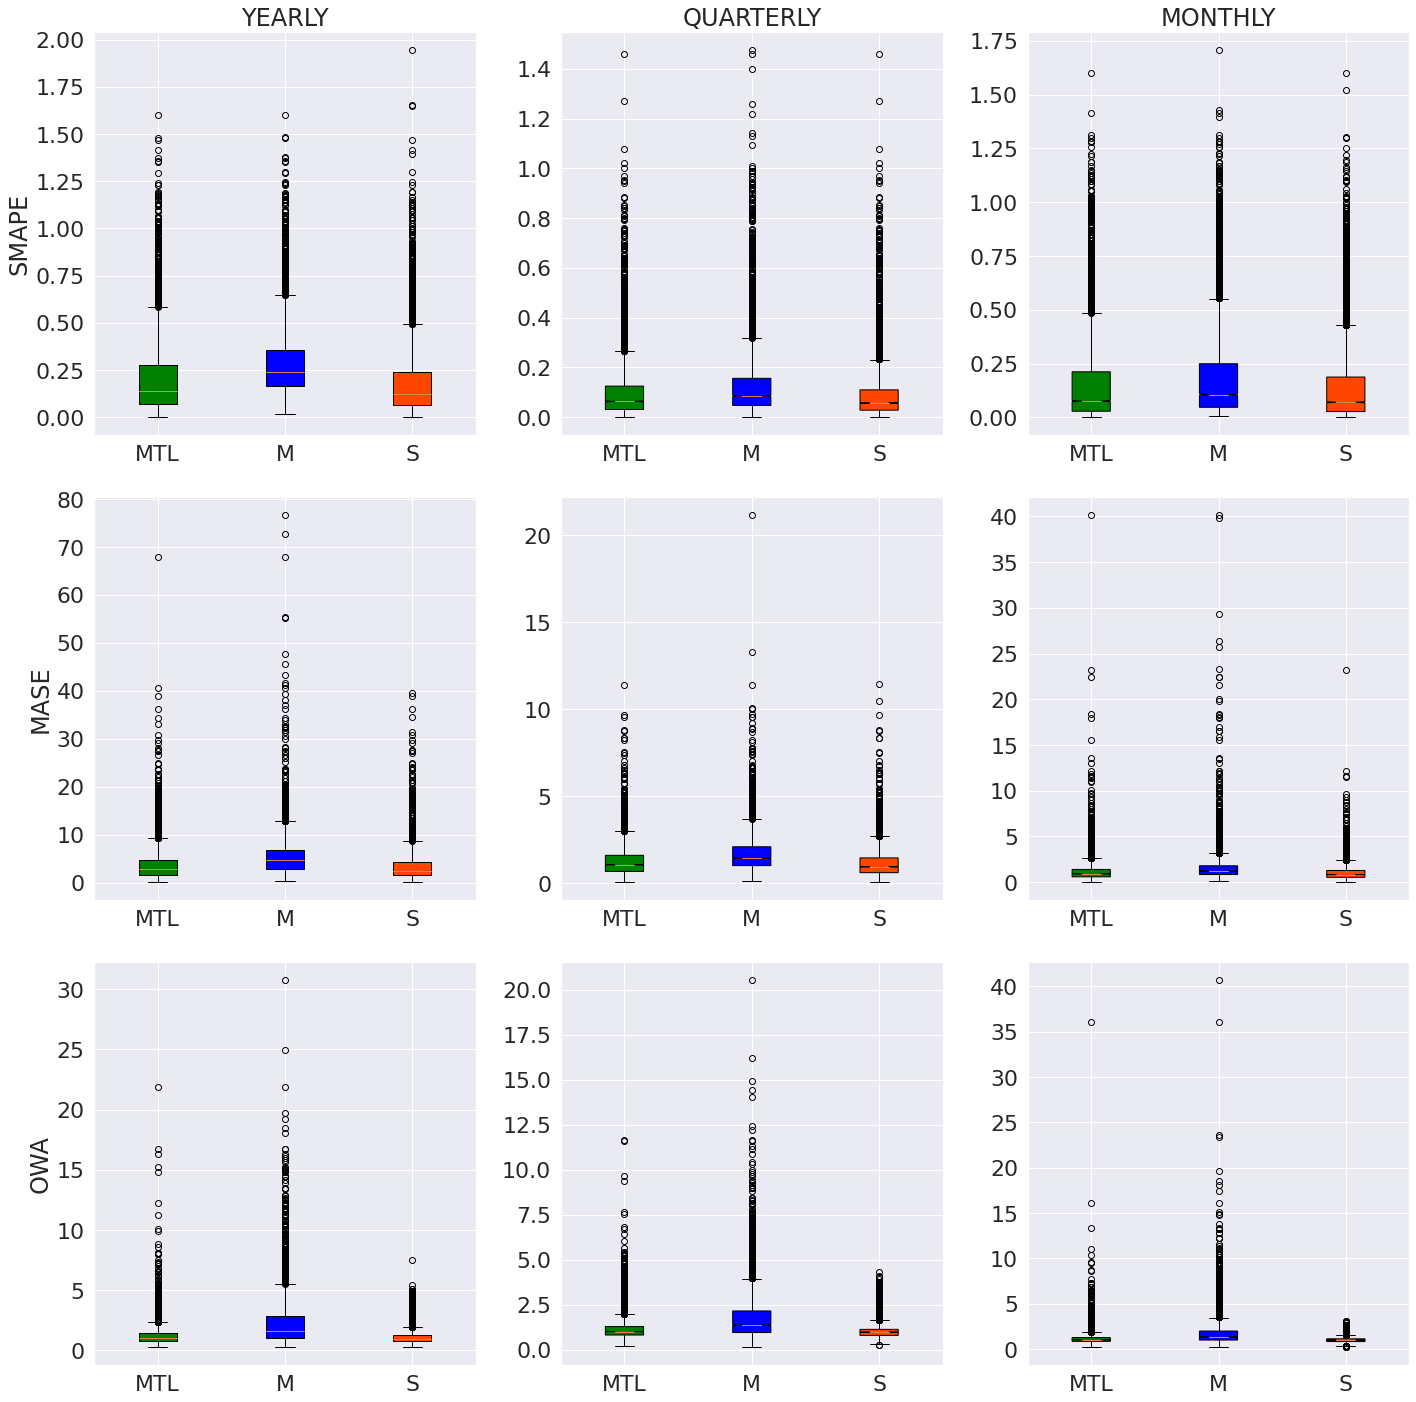

In [27]:
labels = ['MTL', 'M', 'S']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

bplots = [
    ax[0, 0].boxplot([meta_learner["Y"]["SMAPE"], group0["Y"]["SMAPE"], group1["Y"]["SMAPE"]],
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[0, 1].boxplot([meta_learner["Q"]["SMAPE"], group0["Q"]["SMAPE"], group1["Q"]["SMAPE"]],
                     notch=True,                       
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[0, 2].boxplot([meta_learner["M"]["SMAPE"], group0["M"]["SMAPE"], group1["M"]["SMAPE"]],
                     notch=True,                       
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[1, 0].boxplot([meta_learner["Y"]["MASE"], group0["Y"]["MASE"], group1["Y"]["MASE"]],
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[1, 1].boxplot([meta_learner["Q"]["MASE"], group0["Q"]["MASE"], group1["Q"]["MASE"]],
                     notch=True,                       
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[1, 2].boxplot([meta_learner["M"]["MASE"], group0["M"]["MASE"], group1["M"]["MASE"]],
                     notch=True,                       
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[2, 0].boxplot([meta_learner["Y"]["OWA"], group0["Y"]["OWA"], group1["Y"]["OWA"]],
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[2, 1].boxplot([meta_learner["Q"]["OWA"], group0["Q"]["OWA"], group1["Q"]["OWA"]],
                     notch=True,                       
                     vert=True,  
                     patch_artist=True,  
                     labels=labels),
    ax[2, 2].boxplot([meta_learner["M"]["OWA"], group0["M"]["OWA"], group1["M"]["OWA"]],
                     notch=True,                       
                     vert=True,  
                     patch_artist=True,  
                     labels=labels)
]
ax[0, 0].set_title('YEARLY')
ax[0, 1].set_title('QUARTERLY')
ax[0, 2].set_title('MONTHLY')

colors = ['green', 'blue', 'orangered']
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax[0, 0].set_ylabel("SMAPE")
ax[1, 0].set_ylabel("MASE")
ax[2, 0].set_ylabel("OWA")

plt.tight_layout()
plt.savefig("box.png")

## Comparing the Groups

In [28]:
table = {
    "Y":pd.DataFrame({
        "Group 0":[np.nanmean(group0["Y"]["SMAPE"]),  np.nanmean(group0["Y"]["MASE"]),  np.nanmean(group0["Y"]["OWA"])],
        "Group 1":[np.nanmean(group1["Y"]["SMAPE"]),  np.nanmean(group1["Y"]["MASE"]),  np.nanmean(group1["Y"]["OWA"])],
        "Meta Learner":[np.nanmean(meta_learner["Y"]["SMAPE"]),  np.nanmean(meta_learner["Y"]["MASE"]),  np.nanmean(meta_learner["Y"]["OWA"])]
    }),
    "Q":pd.DataFrame({
        "Group 0":[np.nanmean(group0["Q"]["SMAPE"]),  np.nanmean(group0["Q"]["MASE"]),  np.nanmean(group0["Q"]["OWA"])],
        "Group 1":[np.nanmean(group1["Q"]["SMAPE"]),  np.nanmean(group1["Q"]["MASE"]),  np.nanmean(group1["Q"]["OWA"])],
        "Meta Learner":[np.nanmean(meta_learner["Q"]["SMAPE"]),  np.nanmean(meta_learner["Q"]["MASE"]),  np.nanmean(meta_learner["Q"]["OWA"])]
    }),
    "M":pd.DataFrame({
        "Group 0":[np.nanmean(group0["M"]["SMAPE"]),  np.nanmean(group0["M"]["MASE"]),  np.nanmean(group0["M"]["OWA"])],
        "Group 1":[np.nanmean(group1["M"]["SMAPE"]),  np.nanmean(group1["M"]["MASE"]),  np.nanmean(group1["M"]["OWA"])],
        "Meta Learner":[np.nanmean(meta_learner["M"]["SMAPE"]),  np.nanmean(meta_learner["M"]["MASE"]),  np.nanmean(meta_learner["M"]["OWA"])]
    })
}

for d in table.items():
    d[1].index = ["SMAPE", "MASE", "OWA"]

In [29]:
table["Y"]

,Group 0,Group 1,Meta Learner
SMAPE,0.294310,0.192334,0.212941
MASE,5.584253,3.499757,3.771924
OWA,2.412102,1.116192,1.307581


In [30]:
table["Q"]

,Group 0,Group 1,Meta Learner
SMAPE,0.131609,0.094953,0.103403
MASE,1.704533,1.173843,1.274495
OWA,1.797919,1.026385,1.183005


In [31]:
table["M"]

,Group 0,Group 1,Meta Learner
SMAPE,0.178382,0.138627,0.153855
MASE,1.502414,1.018020,1.131346
OWA,1.734778,1.000717,1.143187


In [32]:
def stats_test(interval, metric):
    print(f"Group 0 x Meta Learner: \t{ks_2samp(group0[interval][metric], meta_learner[interval][metric])}")
    print(f"Group 1 x Meta Learner: \t{ks_2samp(group1[interval][metric], meta_learner[interval][metric])}")
    print(f"Group 0 x Group 1: \t\t{ks_2samp(group0[interval][metric], group1[interval][metric])}")
    print("\n\n")

In [33]:
stats_test("Y", "SMAPE")
stats_test("Y", "MASE")
stats_test("Y", "OWA")

Group 0 x Meta Learner: 	KstestResult(statistic=0.3263888888888889, pvalue=4.7824057731871805e-170)
Group 1 x Meta Learner: 	KstestResult(statistic=0.058055555555555555, pvalue=1.0696422987098415e-05)
Group 0 x Group 1: 		KstestResult(statistic=0.37555555555555553, pvalue=2.090445318036096e-226)



Group 0 x Meta Learner: 	KstestResult(statistic=0.2841666666666667, pvalue=2.0525848957343955e-128)
Group 1 x Meta Learner: 	KstestResult(statistic=0.0525, pvalue=9.780487838790676e-05)
Group 0 x Group 1: 		KstestResult(statistic=0.32666666666666666, pvalue=2.4282525125583987e-170)



Group 0 x Meta Learner: 	KstestResult(statistic=0.34, pvalue=8.664925664772607e-185)
Group 1 x Meta Learner: 	KstestResult(statistic=0.07277777777777777, pvalue=1.0323492840646103e-08)
Group 0 x Group 1: 		KstestResult(statistic=0.4111111111111111, pvalue=1.257623296325049e-272)





In [34]:
stats_test("Q", "SMAPE")
stats_test("Q", "MASE")
stats_test("Q", "OWA")

Group 0 x Meta Learner: 	KstestResult(statistic=0.141155712395236, pvalue=8.710580726220414e-40)
Group 1 x Meta Learner: 	KstestResult(statistic=0.040802823114247905, pvalue=0.001052446341059854)
Group 0 x Group 1: 		KstestResult(statistic=0.17931186590207324, pvalue=4.49494836940273e-64)



Group 0 x Meta Learner: 	KstestResult(statistic=0.22055580061755625, pvalue=5.414890883534242e-97)
Group 1 x Meta Learner: 	KstestResult(statistic=0.07278341420379356, pvalue=7.275124686509608e-11)
Group 0 x Group 1: 		KstestResult(statistic=0.29223643581826203, pvalue=4.747900575461361e-171)



Group 0 x Meta Learner: 	KstestResult(statistic=0.29311865902073225, pvalue=4.257288924109228e-172)
Group 1 x Meta Learner: 	KstestResult(statistic=0.09947066607851786, pvalue=6.136634320394274e-20)
Group 0 x Group 1: 		KstestResult(statistic=0.39126599029554476, pvalue=4.84931186584003e-310)





In [35]:
stats_test("M", "SMAPE")
stats_test("M", "MASE")
stats_test("M", "OWA")

Group 0 x Meta Learner: 	KstestResult(statistic=0.13538214321582806, pvalue=6.3755806694029254e-80)
Group 1 x Meta Learner: 	KstestResult(statistic=0.035151149944762476, pvalue=9.05972334042207e-06)
Group 0 x Group 1: 		KstestResult(statistic=0.14974389876468816, pvalue=9.46591908914479e-98)



Group 0 x Meta Learner: 	KstestResult(statistic=0.19001707341568747, pvalue=1.6649112608783583e-157)
Group 1 x Meta Learner: 	KstestResult(statistic=0.06608416189615346, pvalue=2.532909833397406e-19)
Group 0 x Group 1: 		KstestResult(statistic=0.2548960530280205, pvalue=1.717218687445887e-284)



Group 0 x Meta Learner: 	KstestResult(statistic=0.2940644772521844, pvalue=1e-323)
Group 1 x Meta Learner: 	KstestResult(statistic=0.11539620367580597, pvalue=3.9106370515251314e-58)
Group 0 x Group 1: 		KstestResult(statistic=0.4022295872250678, pvalue=0.0)



